In [1]:
import pandas as pd
import numpy as np
import sklearn
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data_url = 'https://raw.githubusercontent.com/shall-it/machine-learning-zoomcamp/refs/heads/main/07-midterm-project/digital-lifestyle.csv'

In [3]:
df = pd.read_csv(data_url)

In [4]:
df.head()

,id,age,gender,region,income_level,education_level,daily_role,device_hours_per_day,phone_unlocks,notifications_per_day,...,sleep_quality,anxiety_score,depression_score,stress_level,happiness_score,focus_score,high_risk_flag,device_type,productivity_score,digital_dependence_score
0,1,40,Female,Asia,High,High School,Part-time/Shift,3.54,45,561,...,3.353627,9.926651,5.0,6.593289,8.0,23.0,0,Android,70.000000,25.700000
1,2,27,Male,Africa,Lower-Mid,Master,Full-time Employee,5.65,100,393,...,2.908147,4.000000,4.0,4.126926,8.1,35.0,0,Laptop,64.000000,30.100000
2,3,31,Male,North America,Lower-Mid,Bachelor,Full-time Employee,8.87,181,231,...,2.889213,4.000000,8.0,1.429139,7.6,15.0,0,Android,65.299301,40.600000
3,4,41,Female,Middle East,Low,Master,Caregiver/Home,4.05,94,268,...,3.097488,7.093357,9.0,4.995512,7.8,28.0,1,Tablet,80.000000,36.684152
4,5,26,Female,Europe,Lower-Mid,Bachelor,Full-time Employee,13.07,199,91,...,2.786098,7.028125,15.0,9.448757,4.2,70.0,1,Android,65.299301,48.400000


In [5]:
df.dtypes

id                            int64
age                           int64
gender                       object
region                       object
income_level                 object
education_level              object
daily_role                   object
device_hours_per_day        float64
phone_unlocks                 int64
notifications_per_day         int64
social_media_mins             int64
study_mins                    int64
physical_activity_days      float64
sleep_hours                 float64
sleep_quality               float64
anxiety_score               float64
depression_score            float64
stress_level                float64
happiness_score             float64
focus_score                 float64
high_risk_flag                int64
device_type                  object
productivity_score          float64
digital_dependence_score    float64
dtype: object

In [6]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for cat_col in categorical_columns:
    df[cat_col] = df[cat_col].str.lower().str.replace(' ', '_')

In [7]:
df.head()

,id,age,gender,region,income_level,education_level,daily_role,device_hours_per_day,phone_unlocks,notifications_per_day,...,sleep_quality,anxiety_score,depression_score,stress_level,happiness_score,focus_score,high_risk_flag,device_type,productivity_score,digital_dependence_score
0,1,40,female,asia,high,high_school,part-time/shift,3.54,45,561,...,3.353627,9.926651,5.0,6.593289,8.0,23.0,0,android,70.000000,25.700000
1,2,27,male,africa,lower-mid,master,full-time_employee,5.65,100,393,...,2.908147,4.000000,4.0,4.126926,8.1,35.0,0,laptop,64.000000,30.100000
2,3,31,male,north_america,lower-mid,bachelor,full-time_employee,8.87,181,231,...,2.889213,4.000000,8.0,1.429139,7.6,15.0,0,android,65.299301,40.600000
3,4,41,female,middle_east,low,master,caregiver/home,4.05,94,268,...,3.097488,7.093357,9.0,4.995512,7.8,28.0,1,tablet,80.000000,36.684152
4,5,26,female,europe,lower-mid,bachelor,full-time_employee,13.07,199,91,...,2.786098,7.028125,15.0,9.448757,4.2,70.0,1,android,65.299301,48.400000


In [8]:
df.isnull().sum()

id                          0
age                         0
gender                      0
region                      0
income_level                0
education_level             0
daily_role                  0
device_hours_per_day        0
phone_unlocks               0
notifications_per_day       0
social_media_mins           0
study_mins                  0
physical_activity_days      0
sleep_hours                 0
sleep_quality               0
anxiety_score               0
depression_score            0
stress_level                0
happiness_score             0
focus_score                 0
high_risk_flag              0
device_type                 0
productivity_score          0
digital_dependence_score    0
dtype: int64

In [9]:
df.describe().round()

,id,age,device_hours_per_day,phone_unlocks,notifications_per_day,social_media_mins,study_mins,physical_activity_days,sleep_hours,sleep_quality,anxiety_score,depression_score,stress_level,happiness_score,focus_score,high_risk_flag,productivity_score,digital_dependence_score
count,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0,3500.0
mean,1750.0,28.0,7.0,147.0,335.0,159.0,108.0,3.0,7.0,3.0,7.0,9.0,5.0,6.0,42.0,0.0,65.0,37.0
std,1011.0,9.0,3.0,68.0,240.0,133.0,80.0,2.0,1.0,1.0,5.0,6.0,3.0,3.0,24.0,0.0,10.0,14.0
min,1.0,13.0,0.0,9.0,22.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,33.0,6.0
25%,876.0,21.0,5.0,96.0,170.0,68.0,42.0,2.0,6.0,2.0,4.0,4.0,1.0,4.0,25.0,0.0,59.0,26.0
50%,1750.0,27.0,7.0,136.0,268.0,119.0,102.0,3.0,7.0,3.0,6.0,8.0,5.0,8.0,44.0,0.0,65.0,35.0
75%,2625.0,34.0,9.0,187.0,434.0,204.0,163.0,5.0,8.0,3.0,9.0,13.0,9.0,9.0,59.0,0.0,71.0,45.0
max,3500.0,50.0,17.0,374.0,1211.0,631.0,418.0,7.0,11.0,5.0,27.0,27.0,10.0,10.0,100.0,1.0,95.0,89.0


In [10]:
categorical_features = list(df.dtypes[df.dtypes == 'object'].index)
categorical_features

['gender',
 'region',
 'income_level',
 'education_level',
 'daily_role',
 'device_type']

In [11]:
numerical = list(df.select_dtypes(include=['int64', 'float64']).columns)
numerical

['id',
 'age',
 'device_hours_per_day',
 'phone_unlocks',
 'notifications_per_day',
 'social_media_mins',
 'study_mins',
 'physical_activity_days',
 'sleep_hours',
 'sleep_quality',
 'anxiety_score',
 'depression_score',
 'stress_level',
 'happiness_score',
 'focus_score',
 'high_risk_flag',
 'productivity_score',
 'digital_dependence_score']

In [12]:
numerical_features = [col for col in numerical if col != 'high_risk_flag']
numerical_features

['id',
 'age',
 'device_hours_per_day',
 'phone_unlocks',
 'notifications_per_day',
 'social_media_mins',
 'study_mins',
 'physical_activity_days',
 'sleep_hours',
 'sleep_quality',
 'anxiety_score',
 'depression_score',
 'stress_level',
 'happiness_score',
 'focus_score',
 'productivity_score',
 'digital_dependence_score']

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [15]:
len(df_train), len(df_val), len(df_test)

(2100, 700, 700)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = df_train.high_risk_flag.values
y_val = df_val.high_risk_flag.values
y_test = df_test.high_risk_flag.values

In [18]:
del df_train['high_risk_flag']
del df_val['high_risk_flag']
del df_test['high_risk_flag']

In [19]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [20]:
C_values = [0.01, 0.1, 1, 10, 100]
accuracies = {}
aucs = {}

for C in C_values:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    risk_decision = (y_pred >= 0.5)
    accuracy = (y_val == risk_decision).mean().round(3)
    accuracies[C] = accuracy
    auc = roc_auc_score(y_val, y_pred).round(3)
    aucs[C] = auc 

for c, a in accuracies.items():
    print(f"C={c}: accuracy={a}")

for c, a in aucs.items():
    print(f"C={c}: auc={a}")

best_C_acc = min([c for c in C_values if accuracies[c] == max(accuracies.values())])
print(f"\n Best C_acc: {best_C_acc} with accuracy {accuracies[best_C_acc]}")

best_C_auc = min([c for c in C_values if aucs[c] == max(aucs.values())])
print(f"\n Best C_auc: {best_C_auc} with auc {aucs[best_C_auc]}")

C=0.01: accuracy=0.811
C=0.1: accuracy=0.817
C=1: accuracy=0.823
C=10: accuracy=0.823
C=100: accuracy=0.819
C=0.01: auc=0.747
C=0.1: auc=0.742
C=1: auc=0.739
C=10: auc=0.739
C=100: auc=0.741

 Best C_acc: 1 with accuracy 0.823

 Best C_auc: 0.01 with auc 0.747


In [21]:
C_best = 0.01

In [22]:
pipeline = make_pipeline(
    DictVectorizer(sparse=False),
    LogisticRegression(solver='liblinear', C=C_best, max_iter=1000, random_state=42)
)

In [23]:
train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')

In [24]:
pipeline.fit(train_dict, y_train)

Pipeline(steps=[('dictvectorizer', DictVectorizer(sparse=False)),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=42,
                                    solver='liblinear'))])

In [25]:
y_pred = pipeline.predict_proba(val_dict)[:, 1]
risk_decision = (y_pred >= 0.5)
accuracy = (y_val == risk_decision).mean().round(3)
auc = roc_auc_score(y_val, y_pred).round(3)

In [26]:
accuracy

np.float64(0.811)

In [27]:
auc

np.float64(0.747)

In [28]:
with open ('model.bin', 'wb') as f_out:
    pickle.dump(pipeline, f_out)

In [29]:
with open ('model.bin', 'rb') as f_in:
    pipeline = pickle.load(f_in)

In [30]:
person = {
    "id": 5,
    "age": 26,
    "gender": "female",
    "region": "europe",
    "income_level": "lower-mid",
    "education_level": "bachelor",
    "daily_role": "full-time_employee",
    "device_hours_per_day": 13.07,
    "phone_unlocks": 199,
    "notifications_per_day": 91,
    "social_media_mins": 147,
    "study_mins": 60,
    "physical_activity_days": 1.0,
    "sleep_hours": 4.197962,
    "sleep_quality": 2.786098,
    "anxiety_score": 7.028125,
    "depression_score": 15.0,
    "stress_level": 9.448757,
    "happiness_score": 4.2,
    "focus_score": 70.0,
    "device_type": "android",
    "productivity_score": 65.299301,
    "digital_dependence_score": 48.4
}

In [31]:
risk_score = pipeline.predict_proba(person)[0, 1]

print('Prob of risk score =', risk_score)

if risk_score >= 0.5:
    print('High risk! Time to take care of your digital and mental health')
else:
    print('Congratulations! Your digital and mental health are OK, risk is low')

Prob of risk score = 0.511376542126206
High risk! Time to take care of your digital and mental health


In [32]:
scores = []

for n in range(10, 201, 10):

    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((n, auc))

In [33]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

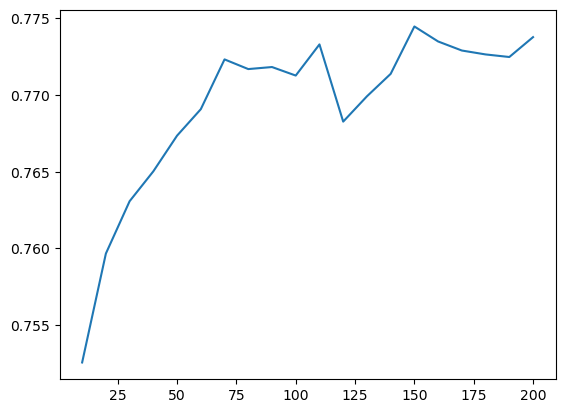

In [34]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.show()

In [35]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [36]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

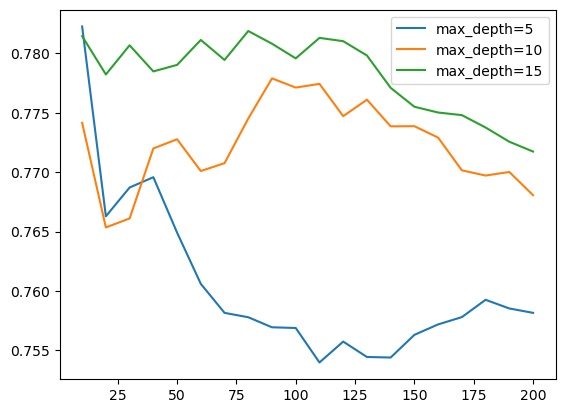

In [37]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()
plt.show()

In [38]:
max_depth = 15

In [39]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [40]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

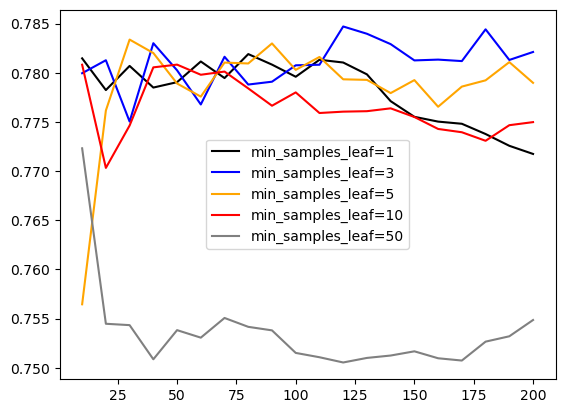

In [41]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()
plt.show()

In [42]:
min_samples_leaf = 3

In [43]:
rf = RandomForestClassifier(n_estimators=120,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred).round(3)
auc

np.float64(0.785)

In [44]:
xgb.DMatrix(X_train, label=y_train)

In [45]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [46]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [47]:
y_pred = model.predict(dval)

In [48]:
roc_auc_score(y_val, y_pred)

np.float64(0.7818634259259258)

In [49]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [50]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [51]:
s = output.stdout

In [52]:
print(s[:200])

[0]	train-auc:0.86362	val-auc:0.77139
[5]	train-auc:0.95017	val-auc:0.78362
[10]	train-auc:0.97608	val-auc:0.78662
[15]	train-auc:0.98982	val-auc:0.77778
[20]	train-auc:0.99616	val-auc:0.77973
[25]	tr


In [53]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [54]:
df_score = parse_xgb_output(output)

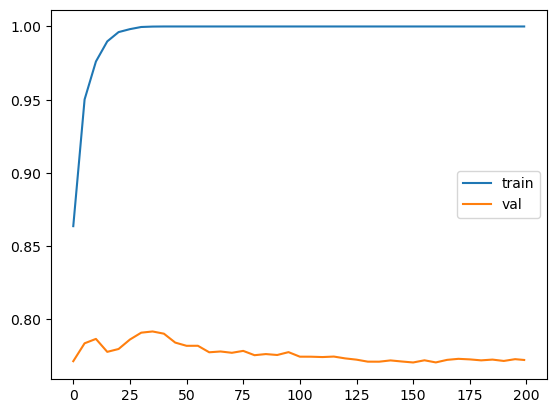

In [55]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()

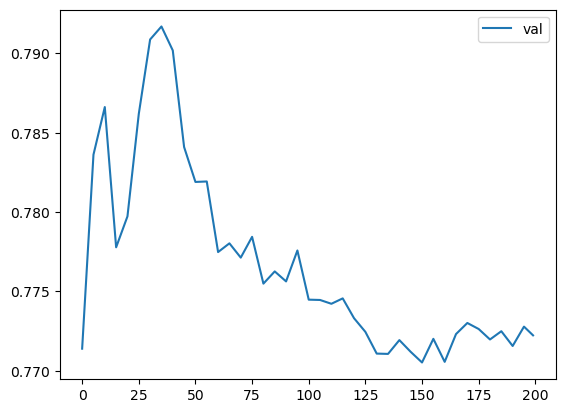

In [56]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()

In [57]:
scores = {}

In [58]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [59]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [60]:
scores.keys()

dict_keys(['eta=0.3'])

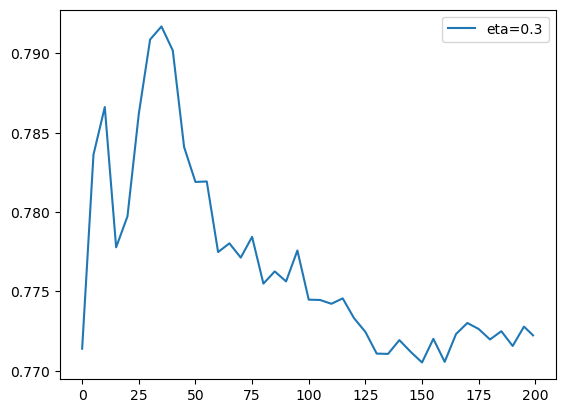

In [61]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()
plt.show()

In [62]:
# etas = ['eta=0.1', 'eta=0.05', 'eta=0.3']

# for eta in etas:
#     df_score = scores[eta]
#     plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
# plt.legend()
# plt.show()

In [63]:
scores = {}

In [64]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [65]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

In [66]:
scores.keys()

dict_keys(['max_depth=6'])

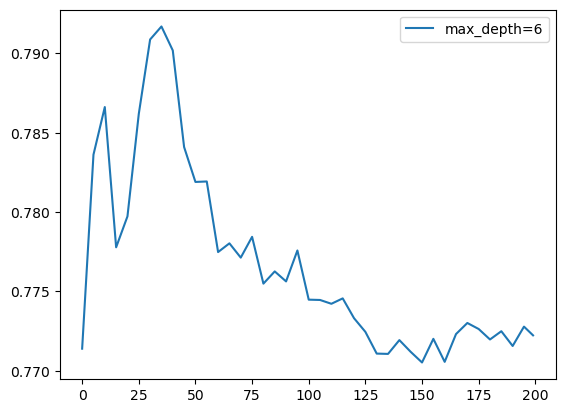

In [67]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()
plt.show()

In [68]:
scores = {}

In [69]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [70]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

In [71]:
scores.keys()

dict_keys(['min_child_weight=30'])

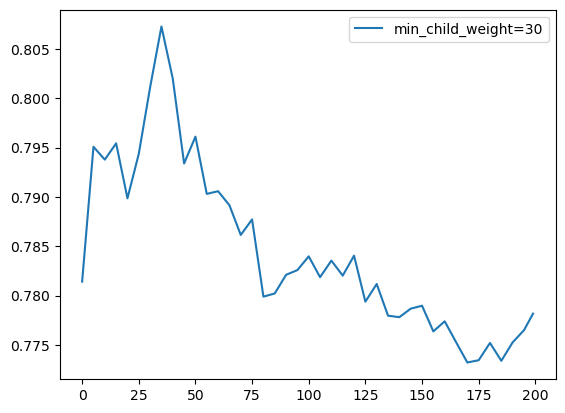

In [72]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.legend()
plt.show()

In [73]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=35)

In [74]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred).round(3)

np.float64(0.806)

In [75]:
df_full_train = df_full_train.reset_index(drop=True)

In [76]:
y_full_train = df_full_train.high_risk_flag.values

In [77]:
del df_full_train['high_risk_flag']

In [78]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [79]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out().tolist())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [80]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=35)

In [81]:
y_pred = model.predict(dtest)

In [82]:
roc_auc_score(y_test, y_pred)

np.float64(0.7266522031489868)